In [81]:
import numpy as np
import pandas as pd

# EDA 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

from datetime import timedelta

In [82]:
# data load
train_df = pd.read_csv('train.csv', encoding='CP949')

In [83]:
train = train_df

In [84]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [85]:
# 컬럼명 영문으로 변경하기
train.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
# test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [86]:
train.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


승현님 코드 참고

In [87]:
train['date'] = train['datetime'].apply(lambda x: x.split()[0])
train['datetime'] = train['datetime'].apply(lambda x: x.split()[1])
# train['date_time'] = train['date_time'].str.rjust(8,'0') # 한자릿수 시간 앞에 0 추가 ex) 3시 -> 03시

# 24시를 00시로 바꿔주기
train.loc[train['datetime']=='24:00:00','datetime'] = '00:00:00'
train['datetime'] = train['date'] + ' ' + train['datetime']
train['datetime'] = pd.to_datetime(train['datetime'])
train.loc[train['datetime'].dt.hour==0,'datetime'] += timedelta(days=1)

In [88]:
train['month'] = train['datetime'].dt.month
train['date'] = train['datetime'].dt.date
train['hour'] = train['datetime'].dt.hour

In [89]:
mean_date = train.groupby('date').mean()
mean_date

,num,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,month,hour
date,,,,,,,,,,,
2020-06-01,30.5,2075.973509,20.386812,3.000290,67.148551,0.013986,0.484275,0.683333,0.483333,6.0,12.0
2020-06-02,30.5,2032.467582,18.953194,2.084514,65.334028,0.053542,0.175069,0.683333,0.483333,6.0,11.5
2020-06-03,30.5,2121.407665,21.606181,2.150208,76.361806,0.002569,0.288542,0.683333,0.483333,6.0,11.5
2020-06-04,30.5,2210.806437,22.690278,2.451736,78.574306,0.008333,0.307986,0.683333,0.483333,6.0,11.5
2020-06-05,30.5,2199.939486,22.869514,1.747847,75.467361,0.000000,0.362361,0.683333,0.483333,6.0,11.5
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-21,30.5,2697.454326,27.167014,1.580903,81.099306,0.027431,0.247778,0.683333,0.483333,8.0,11.5
2020-08-22,30.5,2251.552156,25.731181,1.826181,84.099306,0.798264,0.097847,0.683333,0.483333,8.0,11.5
2020-08-23,30.5,2190.462955,26.114583,1.589444,79.353472,0.008681,0.342500,0.683333,0.483333,8.0,11.5


In [90]:
# building1 = train[train['num'] == 1]  승현님 코드 사용시 사용 중지

### 승현님 데이터 사용시 사용 중지
#### 시계열 데이터 불러오기, 전체 칼럼 중 'target'만 선택하여 실행
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Time Series 생성
#dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
### train_df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = train_df['target']
ts = building1['target']
print(type(ts))
ts.head()

In [91]:
# 시계열 데이터 불러오기, 전체 칼럼 중 'target'만 선택하여 실행
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
#dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
# train_df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = mean_date['target']
# ts = building1['target']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


date
2020-06-01    2075.973509
2020-06-02    2032.467582
2020-06-03    2121.407665
2020-06-04    2210.806437
2020-06-05    2199.939486
Name: target, dtype: float64

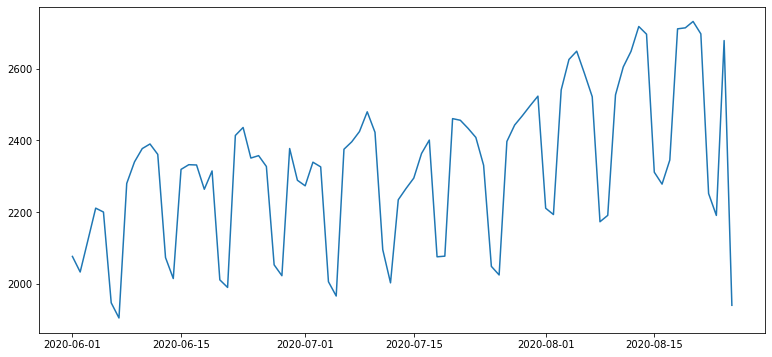

In [92]:
# 결측치 처리 로그 변환
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (13, 6)    # matlab 차트의 기본 크기를 13, 6으로 지정해주기

# 시계열(time series) 데이터를 차트로 그려 보기
plt.plot(ts)

In [93]:
# 결측치 처리 => 결측치가 없음
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: target, dtype: float64)

Series([], Name: target, dtype: float64)


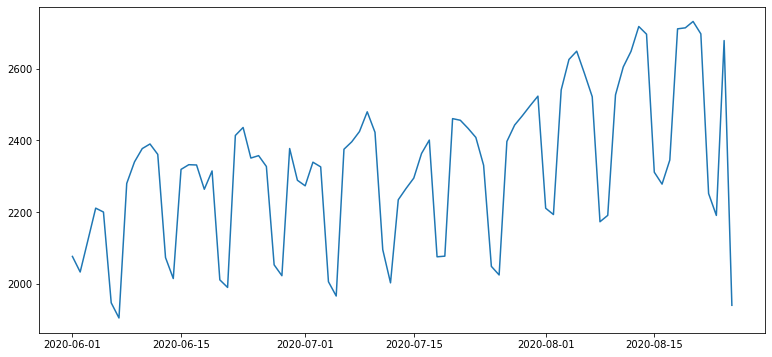

In [94]:
# 결측치가 있다면 이를 보간한다. 보간 기준은 time을 선택. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인하기
print(ts[ts.isna()])

# 다시 그래프를 확인하기
plt.plot(ts)

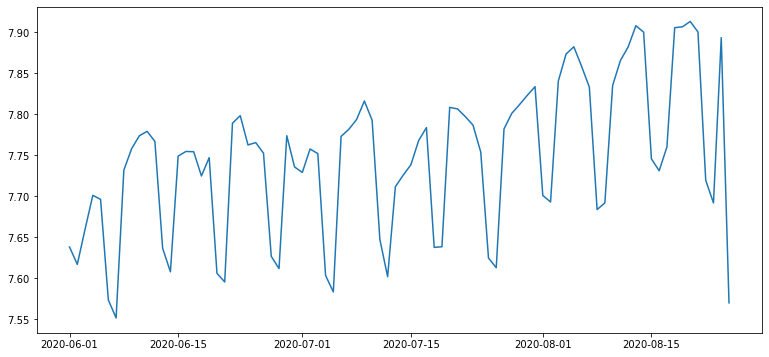

In [95]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

정성적 그래프 분석 정량적 Augmented Dicky-Fuller Test 시계열 분해(Time Series Decomposition) Residual 안정성 확인

Moving average 제거 - 추세(Trend) 상쇄하기

시계열 분석에서 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 한다. 
이 변화량을 제거해 주기 위해 Moving Average, rolling mean을 구해서 ts_log에서 빼준다

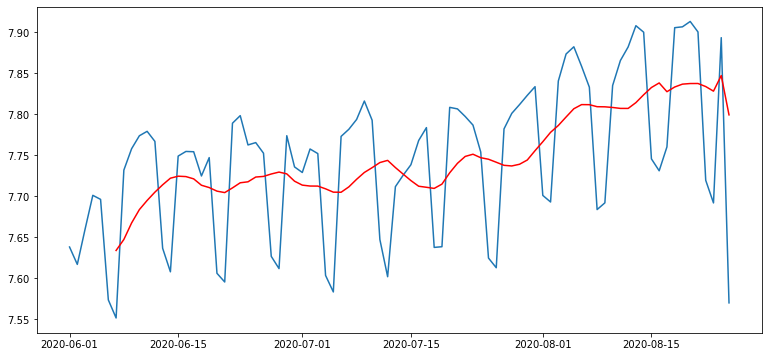

In [96]:
# 시계열 안정성 분석
moving_avg = ts_log.rolling(window=7).mean()  # moving average구하기, 7일 간격으로 이동평균을 구해 봄, 건물 사용이 평일, 휴일에 차이가 발생하므로
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [97]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(20)

date
2020-06-01         NaN
2020-06-02         NaN
2020-06-03         NaN
2020-06-04         NaN
2020-06-05         NaN
2020-06-06         NaN
2020-06-07   -0.082208
2020-06-08    0.084468
2020-06-09    0.090402
2020-06-10    0.089911
2020-06-11    0.084171
2020-06-12    0.061850
2020-06-13   -0.077298
2020-06-14   -0.113984
2020-06-15    0.024484
2020-06-16    0.030604
2020-06-17    0.033033
2020-06-18    0.011284
2020-06-19    0.036469
2020-06-20   -0.100049
Name: target, dtype: float64

Moving Average 계산 시 (windows size=7인 경우) 앞의 6개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다. 
이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시키므로 데이터셋에서 제거해 준다.

In [98]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

date
2020-06-07   -0.082208
2020-06-08    0.084468
2020-06-09    0.090402
2020-06-10    0.089911
2020-06-11    0.084171
2020-06-12    0.061850
2020-06-13   -0.077298
2020-06-14   -0.113984
2020-06-15    0.024484
2020-06-16    0.030604
2020-06-17    0.033033
2020-06-18    0.011284
2020-06-19    0.036469
2020-06-20   -0.100049
2020-06-21   -0.108855
Name: target, dtype: float64

In [99]:
# 이동평균구하기
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


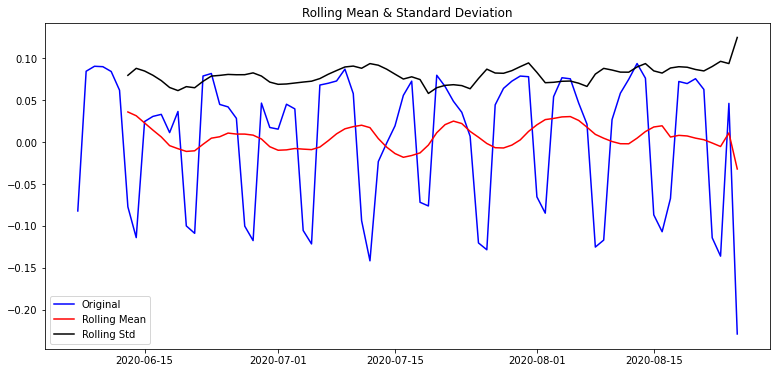

In [100]:
plot_rolling_statistics(ts_log_moving_avg)

In [101]:
# tatsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [102]:
augmented_dickey_fuller_test(ts_log_moving_avg)
# p-value가 0.000131 < 0.05 수준이 되었다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있다

Results of Dickey-Fuller Test:
Test Statistic                 -4.596473
p-value                         0.000131
#Lags Used                      8.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


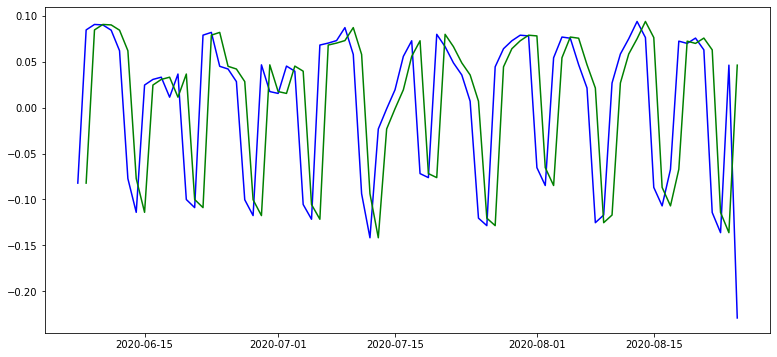

In [103]:
# 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보기
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

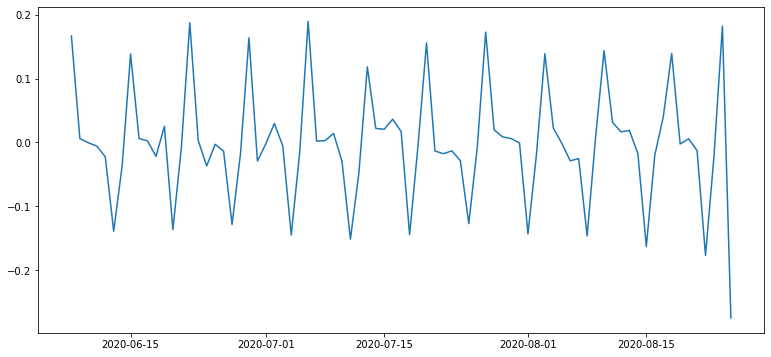

In [104]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

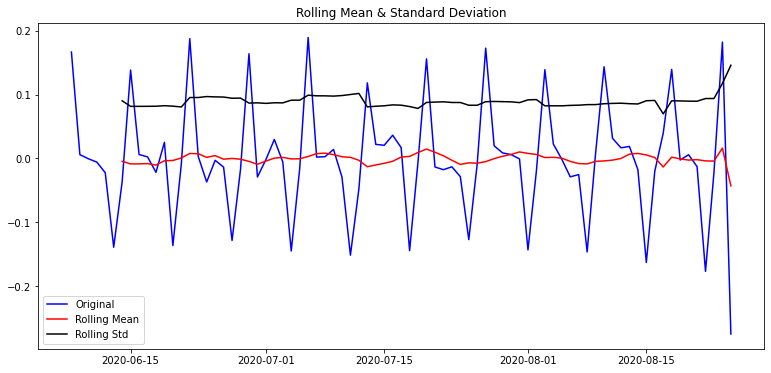

In [105]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악해보기
plot_rolling_statistics(ts_log_moving_avg_diff)

In [106]:
# 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행해 보기
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.020252e+00
p-value                        6.571450e-10
#Lags Used                     1.200000e+01
Number of Observations Used    6.600000e+01
Critical Value (1%)           -3.533560e+00
Critical Value (5%)           -2.906444e+00
Critical Value (10%)          -2.590724e+00
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, 
p-value가 6.571450e-10 < 0.05로 나오는 것으로 보아 차분의 효과가 있음을 알 수 있다.

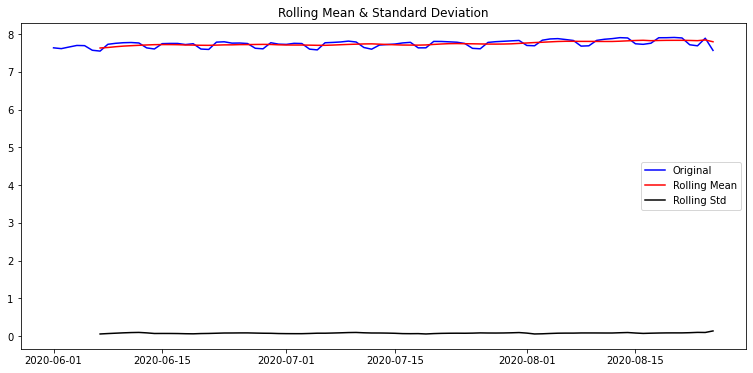

Results of Dickey-Fuller Test:
Test Statistic                 -1.612704
p-value                         0.476557
#Lags Used                      8.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


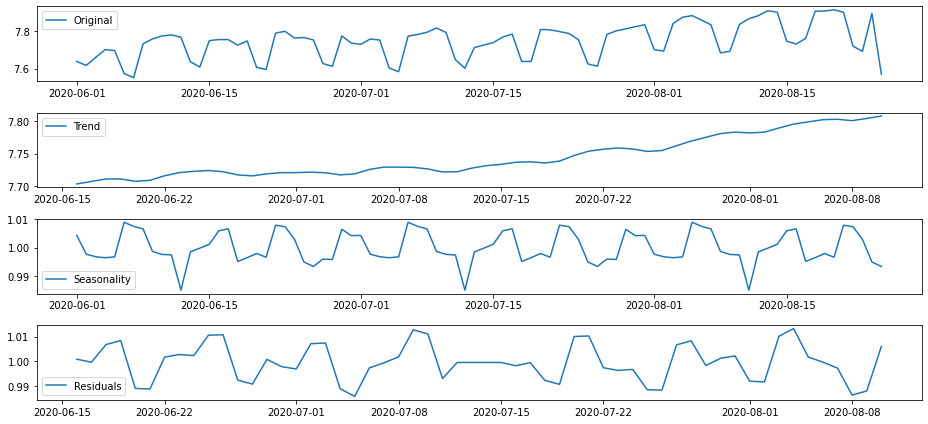

In [107]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=7)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

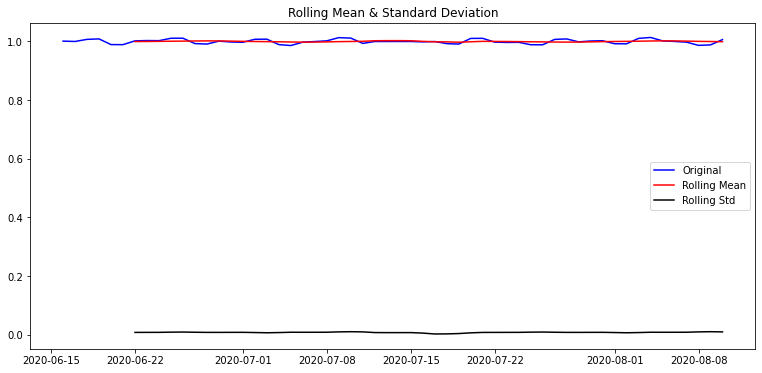

In [108]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

Decomposing을 통해 얻어진 Residual의 p-value : 0.476557 > 0.05 이므로 귀무가설을 기각, 대립가설을 채택한다. 데이타 Residual의 안정성을 확인하기가 어렵다고 할 수 있다.

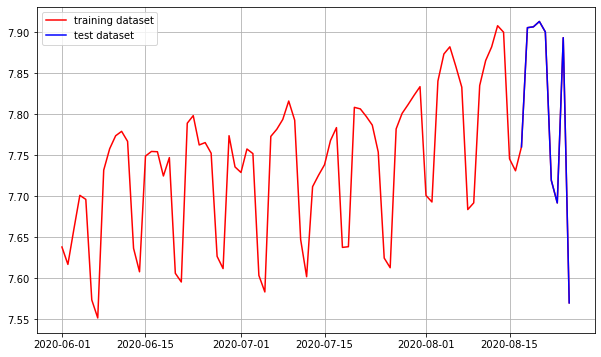

In [109]:
# 학습, 테스트 데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

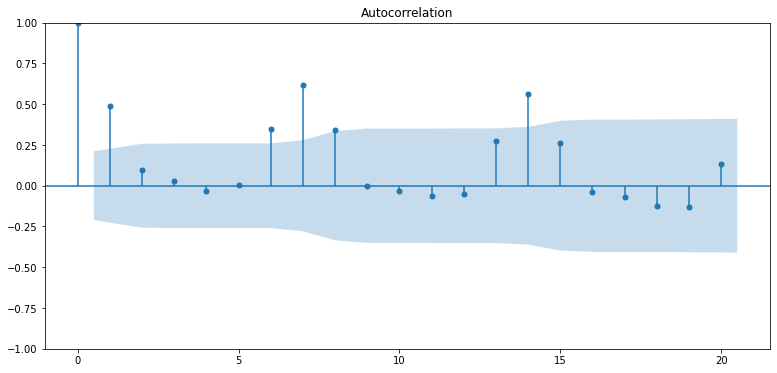

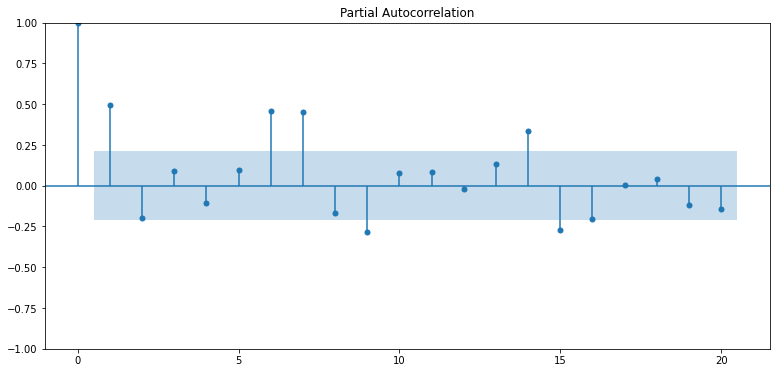

In [110]:
# 적정 ARIMA 모수 찾기 : ACF, PACF 그려보기 -> p,q 구하기 차분 안정성 확인 -> d 구하기
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### PACF 그래프를 볼 때 p=3이 매우 적합한 것 같다. 하지만 이또한 0에 수렴을 하진 않으므로 딱히 그 값을 이용하긴 모호한 점이 있다. ACF 그래프에서 q값은 3-5 범위에서 0에 가깝게 수렴함을 알 수 있다. 하지만 주기성을 가지고 있어 7일 마다 반복되는 양상을 보이고 있다. ACF, PACF를 이용하여 p, d, q 값을 찾는 것은 적절하지 않다고 보인다.

Results of Dickey-Fuller Test:
Test Statistic                 -4.979812
p-value                         0.000024
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.246019e+00
p-value                        4.573977e-08
#Lags Used                     1.200000e+01
Number of Observations Used    7.100000e+01
Critical Value (1%)           -3.526005e+00
Critical Value (5%)           -2.903200e+00
Critical Value (10%)          -2.588995e+00
dtype: float64


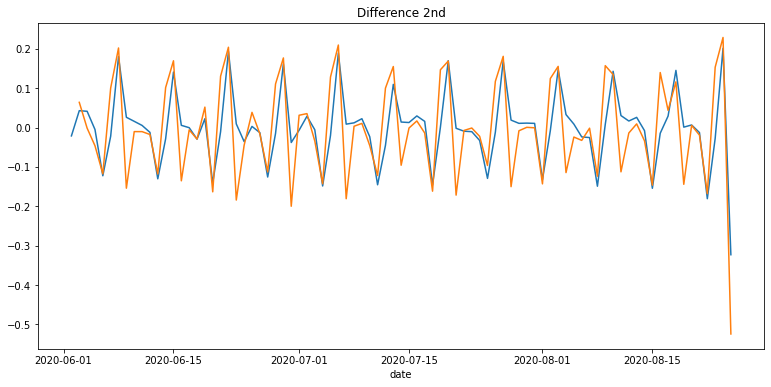

In [111]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분에서 p-value :  0.000024 < 0.05, 2차 차분 결과 p-value :4.573977e-08< 0.05를 보인 것으로 보아 1, 2차 차분한 후에는 모두 안정화 되었으나 2차 차분 후에가 더욱  안정화된 상태라고 할 수 있다.

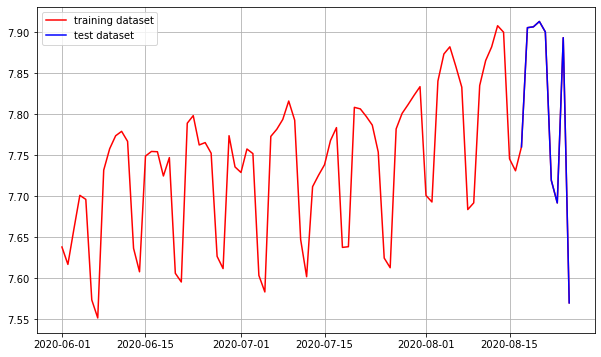

In [112]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [113]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

date
2020-06-01    7.638185
2020-06-02    7.617006
Name: target, dtype: float64
(77,)
(9,)


In [114]:
# 최종 예측 모델 정확도 측정(MAPE)
# ARIMA 모델 훈련하기
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                   77
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  93.033
Date:                Thu, 10 Mar 2022   AIC                           -180.066
Time:                        04:41:19   BIC                           -173.074
Sample:                    06-01-2020   HQIC                          -177.272
                         - 08-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0863      0.278      0.311      0.756      -0.458       0.631
ar.L2         -0.4820      0.087     -5.524      0.000      -0.653      -0.311
sigma2         0.0050      0.001      5.723      0.0

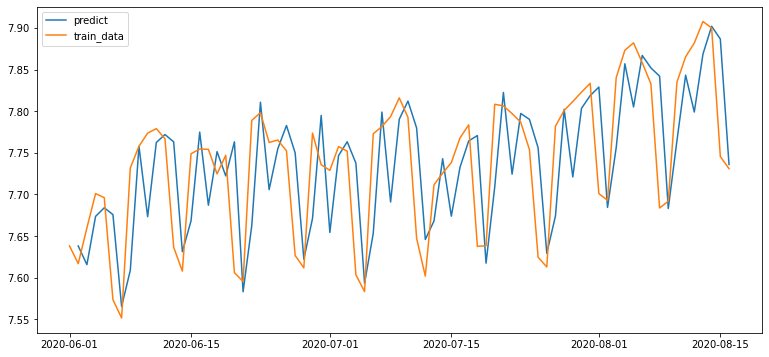

In [115]:
# ARIMA 모델이 훈련 결과를 시각적으로 확인하기
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [116]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                   77
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  93.033
Date:                Thu, 10 Mar 2022   AIC                           -180.066
Time:                        04:41:20   BIC                           -173.074
Sample:                    06-01-2020   HQIC                          -177.272
                         - 08-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0863      0.278      0.311      0.756      -0.458       0.631
ar.L2         -0.4820      0.087     -5.524      0.000      -0.653      -0.311
sigma2         0.0050      0.001      5.723      0.0

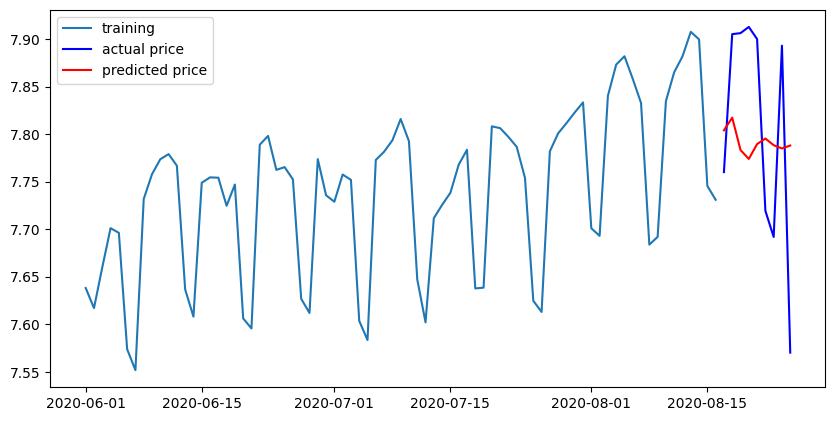

In [117]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  82909.92402477855
MAE:  270.0794221890213
RMSE:  287.9408342433885
MAPE: 11.17%


(p, d, q)에 따른 MAPE값 (1, 1, 1) : 11.22%, (1, 1, 0) : 11.65%, (2, 1, 0) : 11.17%, (2, 1, 1) : 11.20%, (1, 2, 0) : 24.07%, (1, 2, 1) : 11.72%를 나타낸다. 
여기서 (2, 1, 0)인 경우에 11.17%가 가장 낮은 MAPE값을 보인다. 